# Twitter fake news detection

This notebook presents ML model for predicting if a news tweet is fake or not using BERT.

## Load data

In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install jupyterlab
  !pip install notebook
  !pip install pandas
  !pip install ydata-profiling
  !pip install ipywidgets
  !pip install transformers==4.17
  !pip install torch
  !pip install scikit-learn
  !pip install tensorflow==2.15.1
  !pip install keras==2.15.0
  !pip install tf-keras
  !pip install tensorflow_hub
  !pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.3/383.3 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstallin

In [2]:
import pandas as pd
from transformers import AutoModel, BertTokenizerFast, TFBertModel, AutoTokenizer, BertTokenizer, AdamW
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input,Concatenate
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import re
from sklearn.cluster import KMeans
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.metrics import classification_report

%matplotlib inline

In [3]:
url='https://drive.google.com/file/d/1cT8q8-rU-5T7TEKAB5oGkIAhS6dOD3O9/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_csv(url, delimiter=';')
data.head()

,site,retweetCount,quoteCount,likeCount,replyCount,rawContent,retweetedTweet,quotedTweet,real
0,eltiempo,13,0,23,1,☀️¡Buenos días! Amanecemos con las noticias má...,False,False,1
1,eltiempo,0,0,1,0,#Deportes | Dayro Moreno: el insólito regalo q...,False,False,1
2,eltiempo,0,0,5,2,"Néstor Lorenzo, el técnico de la Selección, ah...",False,False,1
3,eltiempo,2,0,4,1,"🔴#EnVivo | Diego Torres, representante de los ...",False,False,1
4,eltiempo,1,0,0,0,🔴 Bienvenido a #CityNoticiasMD. Conéctese para...,False,False,1


## Data analysis

### Dictionary

Dataset contains the following fields

- site: Twitter account that tweeted the news, we divided this in two categories, official and recognized new sites (e.g. @eltiempo, @noticiascaracol) and twitter accounts that are recognized for publishing fake news as a satire (e.g. @actualidadpanam, @ChiguireBipolar)
- retweetCount: How many retweets does the tweet have.
- quoteCount: How many quotes does the tweet have.
- likeCount: How many likes does the tweet have.
- replyCount: How many replies does the tweet have.
- rawContent: The raw text of the tweet.
- retweetedTweet: True if the tweet is a retweet, this means that the user did not publish the news but instead retweet it from another site. False if is not a retweet tweet.
- quotedTweet: True if the tweet is a quote, this means that the user did not publish the news but instead quoted it from another site. False if is not a quote from another tweet.
- real: Label that means if the news is fake or not. True if is a real news, False if considered fake.


### Profiling

We start profiling our data in order to analyze their structure.

In [4]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the profiling we found the following insights:

- There are 0.7% duplicate rows which means the dataset contains repeated tweets, we should eliminate this data.
- There is no missing data.
- Site is highly correlated with the label (real), this is expected since all official news sites tweets were considered as real and satire site news were all considered as fake. This is only a informatory field and we should remove it.
- retweetCount, quoteCount, likeCount, replyCount has multiple zeroes and are highly skewed since some accounts may be more famous than others and also some tweets may have been more popular than others. We should not consider this fields considering also that they have high correlation between them.
- retweetedCount and quotedTweed are highly imbalanced this means that the majority of tweets were fully written by the author, we should remove the retweeted and quoted ones cause we do not have information if the account that did the original tweet is realiable or not in order to consider the tweet as fake or real.
- real is balanced so we have almost the same amount for fake and real tweets which is ideal.

## Data transformations

We are going to apply required transformations in order for the algorithms to interpret the text and also we want to remove fields and data entries that were found as not necessary after executing the profiling.

In [5]:
data = data[data['retweetedTweet'] != True]
data = data[data['quotedTweet'] != True]

In [6]:
data = data.drop(columns=[
  'retweetCount', 'quoteCount', 'likeCount', 'replyCount', 'site', 'retweetedTweet', 'quotedTweet'
])
data = data.drop_duplicates()

## Data pre-processing

Before tokenizing the text we want to standardize some parts of each tweet such as emojis, user mentions (@), news URLS and hash tags.

This is important because almost each tweet contains a different URL which difficults that the ML model finds relations between the words and each link, this is why we replace the appearence of a link with the token \<URL\>

In [7]:
def preprocess_text(text):
    # Transform URLs
    text = re.sub(r'http\S+', '<URL>', text)

    # Transform other user mentions
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Delete emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Transform hashtags
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    return text

In [8]:
data['preprocessedContent'] = data['rawContent'].apply(preprocess_text)

## Profiling after preprocessing and transformations

We can see the a preview a profiling report of the data after applying all transformations.

In [9]:
data.head()

,rawContent,real,preprocessedContent
0,☀️¡Buenos días! Amanecemos con las noticias má...,1,¡Buenos días! Amanecemos con las noticias más ...
1,#Deportes | Dayro Moreno: el insólito regalo q...,1,<HASH_TAG> | Dayro Moreno: el insólito regalo ...
2,"Néstor Lorenzo, el técnico de la Selección, ah...",1,"Néstor Lorenzo, el técnico de la Selección, ah..."
3,"🔴#EnVivo | Diego Torres, representante de los ...",1,"<HASH_TAG> | Diego Torres, representante de lo..."
4,🔴 Bienvenido a #CityNoticiasMD. Conéctese para...,1,Bienvenido a <HASH_TAG>. Conéctese para conoc...


In [10]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split data into train, test, and validation

1.   Elemento de la lista
2.   Elemento de la lista



To start with the training we split data into train, test and validation.

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    data['preprocessedContent'],
    data['real'],
    random_state=2024,
    test_size=0.3,
    stratify=data['real']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    random_state=2024,
    test_size=0.5,
    stratify=y_temp
)

## Tokenize data

We plot a series graph in order to determine de max_sequence_length that is going to be used in BERT and tokenization, with this graph we can see that the majority of the texts has 25 words or less.

Text(0, 0.5, 'Number of texts')

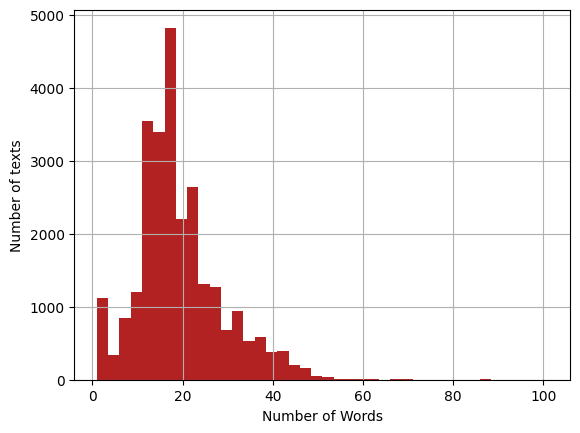

In [12]:
seq_len = [len(title.split()) for title in X_train]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [13]:
MAX_LENGHT = 25

Having determined the max sequence length we are going to tokenize the tweets in the dataset by using pretrained dccuchile/bert-base-spanish-wwm-uncased BERT tokenizer, this is the equivalent of BERT uncased pretrained model but in spanish. We declare a helper function that uses the tokenizer to tokenize a dataset, we do this with train, test and validation.

In [14]:
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def tokenize(data_to_tokenize):
  return tokenizer.batch_encode_plus(
    data_to_tokenize.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
  )

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [15]:
tokens_train = tokenize(X_train)
tokens_val = tokenize(X_val)
tokens_test = tokenize(X_test)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


We now want to convert the result of the tokenization (input_ids and attention_mask) in Pytorch tensors as well as the labels, in order for the BERT algorithm of Pytorch to process it.

In [16]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

We create the data loader required for sampling the data during the training and evaluation processes, we also define a batch size of 32.

In [17]:
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Build model

Freeze BERT parameters so that this pre-trained model is not modified/trained as part of the training process.

In [18]:
bert = AutoModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

for param in bert.parameters():
    param.requires_grad = False

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dens

We create a new class that will specify the layers that the neural network will have, in this case we have the following:

- BERT: Pre-trained language model.
- Dropout: We remove 10% in order to prevent overfitting.
- Dense layer with ReLu: Layer with 768 tensors for finding relations in the data that will output results to ReLu activation function
- Dense layer with Softmax: Layer with 512 tensors that will output results to Softmax activation function in order to decice if the tweet is fake or not

In [19]:
class BERT_model(nn.Module):
    def __init__(self, bert):
      super(BERT_model, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

Initialize BERT model and declare the optimizer and loss function that we are going to use to train the model. In this case we are going to use Adam as optimizer with a learning rate of 1e-5, cross_entropy as loss function and execute for 3 epochs.

In [20]:
model = BERT_model(bert)

optimizer = AdamW(model.parameters(), lr = 1e-5)
cross_entropy  = nn.NLLLoss()
epochs = 50

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train the model

We first define a train function that will contain the logic to train the model, for every 50 batch we will store the current loss and total loss, calculate the gradients in order to update the parameters and clip gradients in order to prevent exploding gradient problem

In [21]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()                                           # Clear previously calculated gradients
    preds = model(sent_id, mask)                                # Get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # Compute loss between actual & predicted values
    total_loss = total_loss + loss.item()
    loss.backward()                                             # Backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # Clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # Update parameters
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)
  return avg_loss

We will also define a evaluate function that will contain the logic to evaluate the model with the validation dataset after training. Every 50 batch we will calculate the current and total loss for the validation dataset.

In [22]:
def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

Having our training and evaluation functions we execute these processes for the required number of epochs by storing the best model seen with best validation loss.

In [23]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    835.
  Batch   100  of    835.
  Batch   150  of    835.
  Batch   200  of    835.
  Batch   250  of    835.
  Batch   300  of    835.
  Batch   350  of    835.
  Batch   400  of    835.
  Batch   450  of    835.
  Batch   500  of    835.
  Batch   550  of    835.
  Batch   600  of    835.
  Batch   650  of    835.
  Batch   700  of    835.
  Batch   750  of    835.
  Batch   800  of    835.

Evaluating...
  Batch    50  of    179.
  Batch   100  of    179.
  Batch   150  of    179.

Training Loss: 0.577
Validation Loss: 0.493

 Epoch 2 / 50
  Batch    50  of    835.
  Batch   100  of    835.
  Batch   150  of    835.
  Batch   200  of    835.
  Batch   250  of    835.
  Batch   300  of    835.
  Batch   350  of    835.
  Batch   400  of    835.
  Batch   450  of    835.
  Batch   500  of    835.
  Batch   550  of    835.
  Batch   600  of    835.
  Batch   650  of    835.
  Batch   700  of    835.
  Batch   750  of    835.
  Batch   800  of    835.


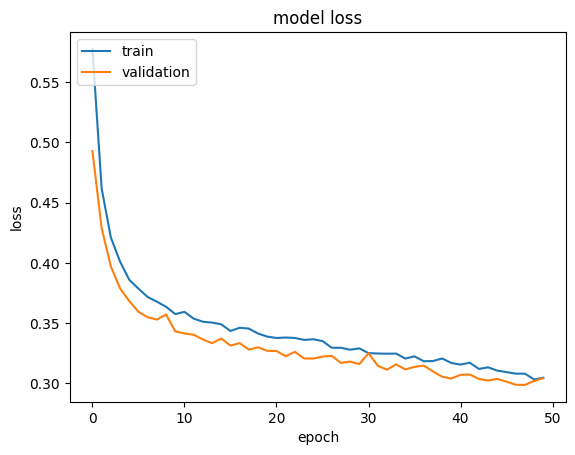

In [24]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validate test dataset

Now we see how does the model behave with the test dataset that it hasnt seen.



In [25]:
path = 'best_model.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2821
           1       0.87      0.92      0.90      2903

    accuracy                           0.89      5724
   macro avg       0.89      0.89      0.89      5724
weighted avg       0.89      0.89      0.89      5724



## Predict new data

As we already have our model we can now test the result with new data.

In [26]:
unseen_news_text = "Segun Chatgpt, el tráfico de X disminuye en 34.6% cuando Petro duerme."
unseen_news_text = preprocess_text(unseen_news_text)

tokens_unseen = tokenizer.batch_encode_plus(
    [unseen_news_text],
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
result = preds[0]

if result == 0:
  print("The news is fake")
else:
  print("The news is real")

The news is fake


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Guardar modelo

In [27]:
torch.save(model, 'model_2.pt')

Upload to drive if in colab

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  !cp model_2.pt /content/drive/My\ Drive/